### Importing Libraries

In [1]:
import os
import numpy as np
#import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import torch
from torch import Tensor
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from transforms import Normalize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


### Define Datasets and Dataloaders

In [3]:
dataset_path = 'data/squares/labeled'

#mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
#std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(p=0.3),
#    transforms.RandomRotation(degrees=40),

    transforms.Resize(100),
    transforms.CenterCrop(95),
    torchvision.transforms.Resize(80),

    transforms.ToTensor(),
    #Normalize(),
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
print(dataset.class_to_idx)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_size = len(dataset) // 30
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (len(dataset)-train_size, train_size))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

print(len(train_dataloader), len(test_dataloader))


{'black': 0, 'empty': 1, 'white': 2}
740 26


### Plot Some Samples of data

In [4]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))


def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []

    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])

            if len(ret) == num:
                break

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))


>>>> torch.Size([4, 3, 80, 80])


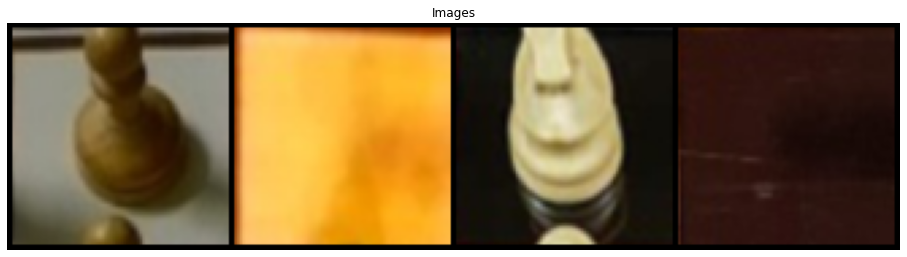

In [5]:
PlotSamples(train_dataloader)
print(">>>>", next(iter(train_dataloader))[0].to(device).shape)


### Defile Model Architecture

In [6]:
from models import SquareClassificationModel

model = SquareClassificationModel().to(device)
summary(model, (3,80,80))





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 78, 78]             140
              ReLU-2            [-1, 5, 78, 78]               0
            Conv2d-3            [-1, 5, 76, 76]             230
              ReLU-4            [-1, 5, 76, 76]               0
         MaxPool2d-5            [-1, 5, 38, 38]               0
            Conv2d-6           [-1, 10, 36, 36]             460
              ReLU-7           [-1, 10, 36, 36]               0
            Conv2d-8           [-1, 10, 34, 34]             910
              ReLU-9           [-1, 10, 34, 34]               0
        MaxPool2d-10           [-1, 10, 17, 17]               0
           Conv2d-11           [-1, 20, 15, 15]           1,820
             ReLU-12           [-1, 20, 15, 15]               0
           Conv2d-13           [-1, 20, 13, 13]           3,620
             ReLU-14           [-1, 20,

### Training Procedure

In [7]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()

    accuracy = []

    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return total_loss / len(train_dataloader) # Returning Average Training Loss

### Testing Procedure

In [8]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

### Model, Optimizer & Loss Function

In [9]:
lr = 0.0001
model = SquareClassificationModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [10]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 201):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')

    if epoch % 10 == 0:
        torch.save(model.state_dict(), 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 1.0927, Accuracy: 0.41, Time: 12.17 sec
Epoch: [1]/(200/740), Train Loss: 1.1387, Accuracy: 0.49, Time: 7.09 sec
Epoch: [1]/(400/740), Train Loss: 0.9466, Accuracy: 0.50, Time: 11.42 sec
Epoch: [1]/(600/740), Train Loss: 0.9325, Accuracy: 0.50, Time: 14.99 sec
Epoch: [1], Test Loss: 0.9363, Accuracy: 0.58, Time: 13.78 sec


Epoch: [2]/(200/740), Train Loss: 0.9675, Accuracy: 0.55, Time: 5.05 sec
Epoch: [2]/(400/740), Train Loss: 0.6118, Accuracy: 0.57, Time: 7.80 sec
Epoch: [2]/(600/740), Train Loss: 0.5889, Accuracy: 0.60, Time: 10.89 sec
Epoch: [2], Test Loss: 0.5586, Accuracy: 0.79, Time: 13.10 sec


Epoch: [3]/(200/740), Train Loss: 0.3484, Accuracy: 0.81, Time: 5.03 sec
Epoch: [3]/(400/740), Train Loss: 0.2900, Accuracy: 0.81, Time: 8.14 sec
Epoch: [3]/(600/740), Train Loss: 0.2496, Accuracy: 0.82, Time: 10.98 sec
Epoch: [3], Test Loss: 0.7365, Accuracy: 0.79, Time: 12.06 sec


Epoch: [4]/(200/740), Train Loss: 0.0810, Accuracy: 0.89, Time: 4.81 sec
Epoch: [

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/boerni/virtualenvs/acid-chess-LXf4eeM8/lib/python3.9/site-packages/torch/__init__.py", line 643, in <module>
    from .functional import *  # noqa: F403
  File "/Users/boerni/virtualenvs/acid-chess-LXf4eeM8/lib/python3.9/site-packages/torch/functional.py", line 6, in <module>
    import torch.nn.functional as F
  File "/Users/boerni/virtualenvs/acid-chess-LXf4eeM8/lib/python3.9/site-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/Users/boerni/virtualenvs/acid-chess-LX

KeyboardInterrupt: 

In [79]:
### Plot Train-Test Loss Curve

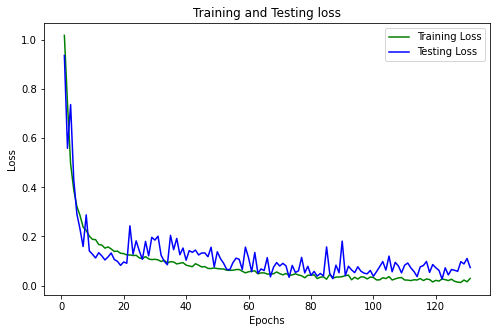

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

### Test on some random images

data/squares/labeled/empty/0001-h-w_2_4.jpeg


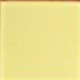

white : 61 % 


data/squares/labeled/empty/0063-v-b_6_5.jpeg


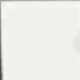

white : 95 % 


data/squares/labeled/empty/0065-h-w_5_7.jpeg


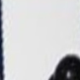

white : 90 % 


data/squares/labeled/empty/0005-h-b_5_1.jpeg


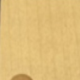

empty : 67 % 


data/squares/labeled/empty/0005-h-b_2_6.jpeg


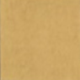

empty : 75 % 


data/squares/labeled/empty/0019-h-w_3_7.jpeg


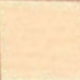

white : 82 % 


data/squares/labeled/empty/0043-v-w_5_2.jpeg


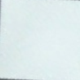

white : 95 % 


data/squares/labeled/empty/9300fd65-d0bb-4898-be9c-e283c2ead3f1.jpg


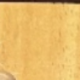

empty : 66 % 


data/squares/labeled/empty/0005-h-b_3_3.jpeg


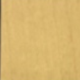

empty : 69 % 


data/squares/labeled/empty/0053-v-b_6_4.jpeg


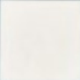

white : 92 % 


data/squares/labeled/empty/0058-h-b_5_3.jpeg


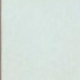

white : 80 % 


data/squares/labeled/empty/0060-h-b_3_1.jpeg


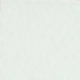

white : 91 % 


data/squares/labeled/empty/6f65c379-2078-4003-83aa-2649f1d974cc.jpg


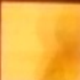

empty : 62 % 


data/squares/labeled/empty/0003-h-b_4_0.jpeg


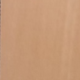

empty : 85 % 


data/squares/labeled/empty/0004-h-b_4_4.jpeg


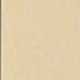

empty : 59 % 


data/squares/labeled/empty/1bbfabaf-2406-4df2-bbdc-591324709a63.jpg


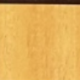

empty : 69 % 


data/squares/labeled/empty/d0d40640-deb7-4856-8b67-35ade3123f41.jpg


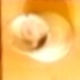

white : 98 % 


data/squares/labeled/empty/bbbd5d96-cd71-4852-94a8-63f4a66c7ce0.jpg


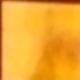

empty : 69 % 


data/squares/labeled/empty/a79ced5d-ad2a-471d-a7e3-a7b0fc92101d.jpg


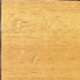

empty : 70 % 


data/squares/labeled/empty/b5bb6040-80ce-475e-a70b-d24676bdf36e.jpg


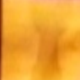

empty : 74 % 


data/squares/labeled/empty/0053-v-b_4_2.jpeg


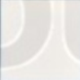

white : 91 % 


data/squares/labeled/empty/0044-h-w_3_3.jpeg


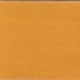

empty : 81 % 


data/squares/labeled/empty/0005-h-b_5_5.jpeg


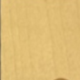

empty : 67 % 


data/squares/labeled/empty/0019-h-w_5_5.jpeg


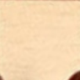

white : 78 % 


data/squares/labeled/empty/0003-h-b_5_1.jpeg


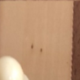

empty : 85 % 


data/squares/labeled/empty/0004-h-b_3_7.jpeg


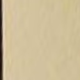

empty : 69 % 


data/squares/labeled/empty/0cbad267-e37a-4d63-9ba1-5b683a29d997.jpg


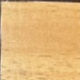

empty : 64 % 


data/squares/labeled/empty/0063-v-b_0_5.jpeg


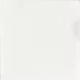

white : 95 % 


data/squares/labeled/empty/0051-v-b_6_5.jpeg


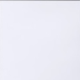

white : 97 % 


data/squares/labeled/empty/e0fa6dba-e977-4ae8-8eb7-ccaf25bbf8b1.jpg


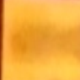

empty : 66 % 


data/squares/labeled/empty/0065-h-w_3_5.jpeg


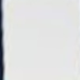

white : 88 % 


data/squares/labeled/empty/90fc430a-0d7c-4fd4-8b06-de2fb214026e.jpg


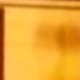

empty : 63 % 


data/squares/labeled/empty/d62d6b27-d620-4f34-94aa-0225645454ff.jpg


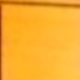

empty : 64 % 


data/squares/labeled/empty/0058-h-b_3_7.jpeg


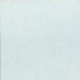

white : 82 % 


data/squares/labeled/empty/0019-h-w_4_4.jpeg


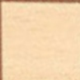

white : 76 % 


data/squares/labeled/empty/0043-v-w_6_5.jpeg


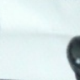

white : 98 % 


data/squares/labeled/empty/0051-v-b_3_4.jpeg


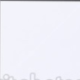

white : 98 % 


data/squares/labeled/empty/0010-h-b_5_3.jpeg


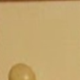

empty : 76 % 


data/squares/labeled/empty/03df68f7-d694-4a37-acd5-7f4d51e15683.jpg


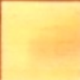

white : 75 % 


data/squares/labeled/empty/0043-v-w_1_4.jpeg


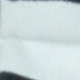

white : 87 % 


data/squares/labeled/empty/0026-v-b_6_3.jpeg


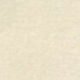

white : 75 % 


data/squares/labeled/empty/0053-v-b_3_5.jpeg


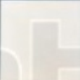

white : 83 % 


data/squares/labeled/empty/0005-h-b_4_6.jpeg


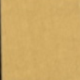

empty : 73 % 


data/squares/labeled/empty/060b8a89-fe91-4cd2-9044-9ad71141a8c0.jpg


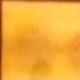

empty : 69 % 


data/squares/labeled/empty/2eef131e-149e-4e96-8cfb-fc0a660b9d39.jpg


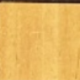

empty : 65 % 


data/squares/labeled/empty/e55aa9f7-200d-41e3-b274-e3d88d630a4e.jpg


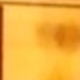

empty : 61 % 


data/squares/labeled/empty/62ab67c8-7879-4037-ab9e-6de61098de41.jpg


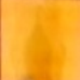

empty : 70 % 


data/squares/labeled/empty/0005-h-b_4_2.jpeg


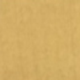

empty : 72 % 


data/squares/labeled/empty/0063-v-b_0_3.jpeg


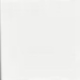

white : 96 % 


data/squares/labeled/empty/0053-v-b_7_5.jpeg


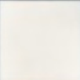

white : 91 % 


data/squares/labeled/empty/f9f53ebd-98e8-4760-866a-1e4d75d9f948.jpg


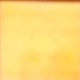

white : 67 % 


data/squares/labeled/empty/51bd0970-9191-4af2-a15c-78ff39f6ea41.jpg


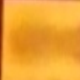

empty : 68 % 


data/squares/labeled/empty/0008-v-w_5_2.jpeg


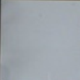

empty : 85 % 


data/squares/labeled/empty/0058-h-b_5_7.jpeg


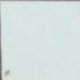

white : 83 % 


data/squares/labeled/empty/0058-h-b_2_6.jpeg


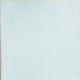

white : 84 % 


data/squares/labeled/empty/0029-h-w_4_1.jpeg


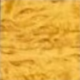

empty : 67 % 


data/squares/labeled/empty/6bd7e44a-14cf-42af-b0b1-59ef37a7afcc.jpg


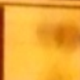

empty : 65 % 


data/squares/labeled/empty/0063-v-w_5_2.jpeg


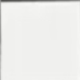

white : 96 % 


data/squares/labeled/empty/388aeae2-1661-42d3-af2b-d27fb5f1de7d.jpg


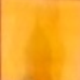

empty : 69 % 


data/squares/labeled/empty/0029-h-w_3_2.jpeg


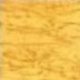

empty : 68 % 


data/squares/labeled/empty/0029-h-w_4_3.jpeg


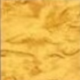

empty : 63 % 


data/squares/labeled/empty/c1e4293d-12fa-4d66-b59a-956fc6cb21a7.jpg


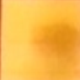

empty : 63 % 


data/squares/labeled/empty/0043-v-w_1_2.jpeg


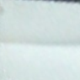

white : 87 % 


data/squares/labeled/empty/89e829e1-6304-4d80-8706-fef77cb251af.jpg


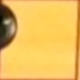

white : 61 % 


data/squares/labeled/empty/0015-h-b_4_4.jpeg


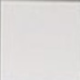

white : 76 % 


data/squares/labeled/empty/0010-h-b_3_3.jpeg


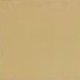

empty : 74 % 


data/squares/labeled/empty/0043-v-w_4_5.jpeg


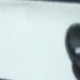

white : 98 % 


data/squares/labeled/empty/2804a768-27df-4e67-a982-d67e216a7673.jpg


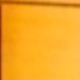

empty : 65 % 


data/squares/labeled/empty/0053-v-b_3_3.jpeg


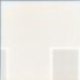

white : 94 % 


data/squares/labeled/empty/0001-h-w_3_5.jpeg


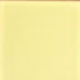

white : 77 % 


data/squares/labeled/empty/0060-h-b_2_2.jpeg


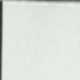

white : 86 % 


data/squares/labeled/empty/041e8939-7315-466c-abda-8ded5ff45297.jpg


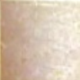

empty : 59 % 


data/squares/labeled/empty/0029-h-w_3_4.jpeg


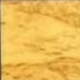

empty : 65 % 


data/squares/labeled/empty/0063-v-b_2_3.jpeg


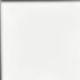

white : 96 % 


data/squares/labeled/empty/0063-v-w_4_5.jpeg


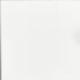

white : 96 % 


data/squares/labeled/empty/ec1d9cc5-b74f-40fb-960a-f2ae53fcf856.jpg


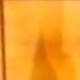

empty : 72 % 


data/squares/labeled/empty/020d8959-1de7-4a72-9d18-d261dd692e27.jpg


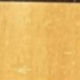

empty : 68 % 


data/squares/labeled/empty/0048-h-b_5_7.jpeg


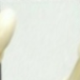

white : 92 % 


data/squares/labeled/empty/0004-h-b_2_4.jpeg


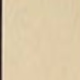

empty : 61 % 


data/squares/labeled/empty/6d97eaf5-f670-4e14-af4f-44e4b88c9fb5.jpg


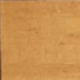

empty : 82 % 


data/squares/labeled/empty/0005-h-b_2_2.jpeg


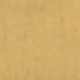

empty : 72 % 


data/squares/labeled/empty/0051-v-b_2_3.jpeg


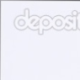

white : 98 % 


data/squares/labeled/empty/0058-h-b_3_5.jpeg


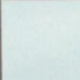

white : 86 % 


data/squares/labeled/empty/0051-v-b_6_3.jpeg


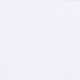

white : 98 % 


data/squares/labeled/empty/0010-h-b_2_2.jpeg


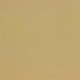

empty : 77 % 


data/squares/labeled/empty/0029-h-w_5_0.jpeg


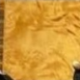

empty : 77 % 


data/squares/labeled/empty/f4c095a7-fc3d-4987-a3eb-9a614833675e.jpg


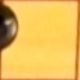

white : 65 % 


data/squares/labeled/empty/0048-h-b_4_4.jpeg


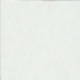

white : 93 % 


data/squares/labeled/empty/4f538d2e-106d-49a9-abfa-b90e9d1d3575.jpg


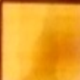

empty : 71 % 


data/squares/labeled/empty/0044-h-w_3_1.jpeg


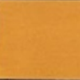

empty : 81 % 


data/squares/labeled/empty/ec43c6bb-7285-4a63-9580-5d044aea5d1f.jpg


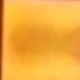

empty : 64 % 


data/squares/labeled/empty/0060-h-b_4_6.jpeg


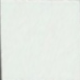

white : 92 % 


data/squares/labeled/empty/0063-v-b_3_2.jpeg


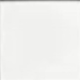

white : 96 % 


data/squares/labeled/empty/7ab5e4dc-bb1b-4694-b4eb-c8b8380fd03a.jpg


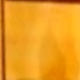

empty : 69 % 


data/squares/labeled/empty/0065-h-w_5_5.jpeg


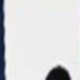

white : 95 % 


data/squares/labeled/empty/0001-h-w_2_2.jpeg


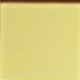

empty : 62 % 


data/squares/labeled/empty/0058-h-b_4_0.jpeg


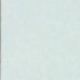

white : 80 % 


data/squares/labeled/empty/0004-h-b_2_6.jpeg


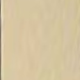

empty : 67 % 


data/squares/labeled/empty/0065-h-w_2_2.jpeg


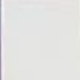

white : 85 % 


data/squares/labeled/empty/0010-h-b_4_2.jpeg


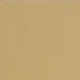

empty : 77 % 


data/squares/labeled/empty/0010-h-b_5_7.jpeg


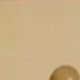

empty : 71 % 


data/squares/labeled/empty/23e9d500-97a4-4c35-b48f-4ce8d6e29d63.jpg


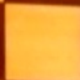

empty : 58 % 


data/squares/labeled/empty/236a08a1-c804-457a-8ef6-e8118012c8fe.jpg


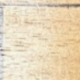

white : 82 % 


data/squares/labeled/empty/0053-v-b_2_4.jpeg


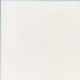

white : 92 % 


data/squares/labeled/empty/0015-h-b_4_2.jpeg


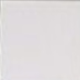

white : 78 % 


data/squares/labeled/empty/0058-h-b_5_1.jpeg


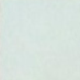

white : 79 % 


data/squares/labeled/empty/0063-v-w_6_3.jpeg


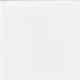

white : 95 % 


data/squares/labeled/empty/7b5311a5-1c36-45b0-8380-ab86f9b4b079.jpg


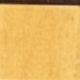

empty : 66 % 


data/squares/labeled/empty/0015-h-b_2_4.jpeg


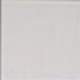

empty : 58 % 


data/squares/labeled/empty/e0a04d97-7970-44eb-b068-ec6f3cb87a81.jpg


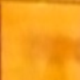

empty : 70 % 


data/squares/labeled/empty/0001-h-w_5_7.jpeg


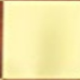

white : 83 % 


data/squares/labeled/empty/101ec20d-24bf-47e1-b2c6-ead09909d42c.jpg


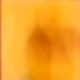

empty : 70 % 


data/squares/labeled/empty/0003-h-b_5_5.jpeg


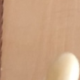

empty : 80 % 


data/squares/labeled/empty/0063-v-b_6_3.jpeg


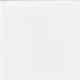

white : 95 % 


data/squares/labeled/empty/0051-v-b_4_5.jpeg


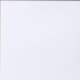

white : 97 % 


data/squares/labeled/empty/0060-h-b_4_4.jpeg


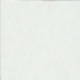

white : 93 % 


data/squares/labeled/empty/0015-h-b_4_0.jpeg


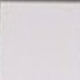

white : 73 % 


data/squares/labeled/empty/ce7fc69e-aae5-4732-a5b9-fa517176eef8.jpg


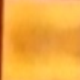

empty : 66 % 


data/squares/labeled/empty/0019-h-w_2_4.jpeg


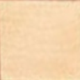

white : 72 % 


data/squares/labeled/empty/0060-h-b_4_2.jpeg


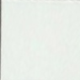

white : 94 % 


data/squares/labeled/empty/d68d0111-22ae-478a-94c5-ffaee34a8b1a.jpg


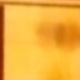

empty : 62 % 


data/squares/labeled/empty/0058-h-b_4_2.jpeg


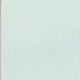

white : 77 % 


data/squares/labeled/empty/0026-v-b_2_5.jpeg


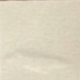

empty : 53 % 


data/squares/labeled/empty/07511464-9ece-4956-87cb-12dc8438eb90.jpg


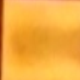

empty : 65 % 


data/squares/labeled/empty/0003-h-b_4_2.jpeg


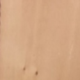

empty : 77 % 


data/squares/labeled/empty/f5d5ba02-43a1-49ef-8acf-811578076f01.jpg


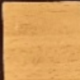

empty : 76 % 


data/squares/labeled/empty/e9813ed3-9b0a-4baf-b6a6-0bb686910075.jpg


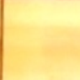

white : 75 % 


data/squares/labeled/empty/0003-h-b_4_4.jpeg


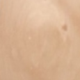

empty : 70 % 


data/squares/labeled/empty/18fca5ff-1cae-4698-885a-84c5835db624.jpg


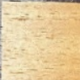

white : 65 % 


data/squares/labeled/empty/19f72bae-9f34-4c57-90ae-528949d5cc5d.jpg


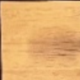

empty : 70 % 


data/squares/labeled/empty/0065-h-w_4_0.jpeg


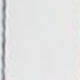

white : 89 % 


data/squares/labeled/empty/77b854f7-49ba-4d97-962f-8f8cfcbbeefb.jpg


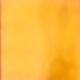

empty : 60 % 


data/squares/labeled/empty/0005-h-b_4_4.jpeg


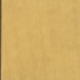

empty : 72 % 


data/squares/labeled/empty/4f011069-5ef4-41e4-98c8-2004ed7a2aa0.jpg


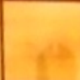

empty : 70 % 


data/squares/labeled/empty/0004-h-b_5_5.jpeg


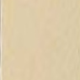

empty : 65 % 


data/squares/labeled/empty/458e4d68-be04-488e-9fc9-1ee46fc2b83d.jpg


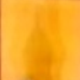

empty : 69 % 


data/squares/labeled/empty/0043-v-w_0_5.jpeg


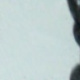

white : 58 % 


data/squares/labeled/empty/f4dd5505-a4af-426a-804c-ffc57a364aa9.jpg


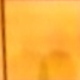

empty : 68 % 


data/squares/labeled/empty/0053-v-b_1_5.jpeg


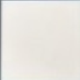

white : 83 % 


data/squares/labeled/empty/4af158ca-5efb-4a12-9ec0-05b3fd8495a3.jpg


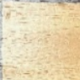

white : 76 % 


data/squares/labeled/empty/0001-h-w_4_0.jpeg


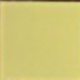

empty : 69 % 


data/squares/labeled/empty/0012-h-w_2_6.jpeg


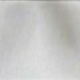

empty : 55 % 


data/squares/labeled/empty/0004-h-b_5_1.jpeg


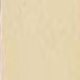

white : 50 % 


data/squares/labeled/empty/0044-h-w_3_5.jpeg


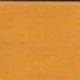

empty : 81 % 


data/squares/labeled/empty/0063-v-w_1_4.jpeg


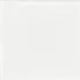

white : 95 % 


data/squares/labeled/empty/0004-h-b_5_3.jpeg


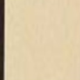

empty : 53 % 


data/squares/labeled/empty/6e7fba55-2617-45e6-805c-5ff923ba9317.jpg


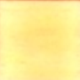

white : 85 % 


data/squares/labeled/empty/80c156ab-55e9-40dc-8654-68d17ee9a834.jpg


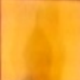

empty : 70 % 


data/squares/labeled/empty/0012-h-w_5_1.jpeg


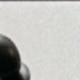

white : 58 % 


data/squares/labeled/empty/0063-v-b_2_5.jpeg


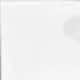

white : 96 % 


data/squares/labeled/empty/4a9d2bb7-db30-418b-b70d-ca16f9d1d9d4.jpg


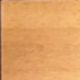

empty : 76 % 


data/squares/labeled/empty/1da6a4df-244f-4388-aa4b-017c4cff45eb.jpg


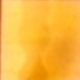

empty : 65 % 


data/squares/labeled/empty/63c0becf-a63e-40af-a5e8-7a08f3324eeb.jpg


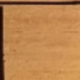

empty : 87 % 


data/squares/labeled/empty/0043-v-w_3_2.jpeg


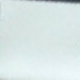

white : 91 % 


data/squares/labeled/empty/0063-v-w_3_4.jpeg


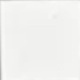

white : 96 % 


data/squares/labeled/empty/125c5e59-1f54-4845-86fa-f951d131d886.jpg


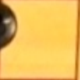

white : 61 % 


data/squares/labeled/empty/420f3cf1-6ac4-4c96-904e-e33906cb23e5.jpg


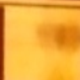

empty : 62 % 


data/squares/labeled/empty/0065-h-w_4_2.jpeg


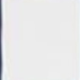

white : 94 % 


data/squares/labeled/empty/9278c843-a436-436c-b3f8-40268e37c26a.jpg


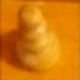

empty : 72 % 


data/squares/labeled/empty/0044-h-w_4_6.jpeg


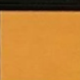

empty : 81 % 


data/squares/labeled/empty/0019-h-w_2_2.jpeg


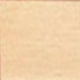

white : 62 % 


data/squares/labeled/empty/0063-v-b_4_3.jpeg


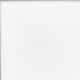

white : 96 % 


data/squares/labeled/empty/0026-v-b_3_2.jpeg


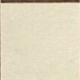

white : 61 % 


data/squares/labeled/empty/0065-h-w_3_3.jpeg


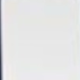

white : 91 % 


data/squares/labeled/empty/0026-v-b_7_2.jpeg


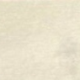

white : 76 % 


data/squares/labeled/empty/dddb2bee-a736-4213-9714-fbdcbac9dec2.jpg


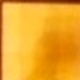

empty : 70 % 


data/squares/labeled/empty/0048-h-b_2_2.jpeg


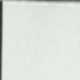

white : 86 % 


data/squares/labeled/empty/564d9af5-0f07-420a-94e9-82b9379d0f9f.jpg


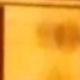

empty : 63 % 


data/squares/labeled/empty/0051-v-b_0_5.jpeg


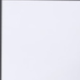

white : 97 % 


data/squares/labeled/empty/0010-h-b_5_5.jpeg


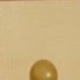

empty : 79 % 


data/squares/labeled/empty/0004-h-b_5_7.jpeg


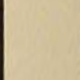

empty : 69 % 


data/squares/labeled/empty/0004-h-b_4_2.jpeg


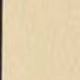

empty : 50 % 


data/squares/labeled/empty/0065-h-w_3_7.jpeg


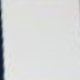

white : 79 % 


data/squares/labeled/empty/0004-h-b_3_1.jpeg


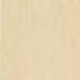

white : 52 % 


data/squares/labeled/empty/94a066fd-ffca-4dce-acea-e617b2a4ae3e.jpg


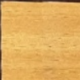

empty : 72 % 


data/squares/labeled/empty/0058-h-b_5_5.jpeg


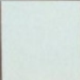

white : 80 % 


data/squares/labeled/empty/0019-h-w_4_2.jpeg


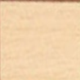

white : 67 % 


data/squares/labeled/empty/0015-h-b_3_1.jpeg


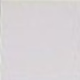

white : 63 % 


data/squares/labeled/empty/0060-h-b_3_7.jpeg


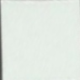

white : 90 % 


data/squares/labeled/empty/0010-h-b_2_4.jpeg


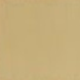

empty : 74 % 


data/squares/labeled/empty/215bad7d-0454-4448-912a-7989e010a698.jpg


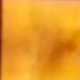

empty : 75 % 


data/squares/labeled/empty/a67ec3ba-8692-448e-86be-6696a03c1bb0.jpg


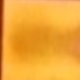

empty : 67 % 


data/squares/labeled/empty/452026e5-b4f0-4716-935f-ba3c3708686b.jpg


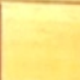

white : 75 % 


data/squares/labeled/empty/0015-h-b_5_1.jpeg


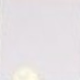

white : 88 % 


data/squares/labeled/empty/0004-h-b_3_5.jpeg


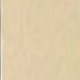

empty : 62 % 


data/squares/labeled/empty/0043-v-w_5_4.jpeg


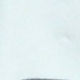

white : 96 % 


data/squares/labeled/empty/f95c5b94-bddc-488e-b0e0-3a99d486f77c.jpg


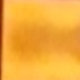

empty : 66 % 


data/squares/labeled/empty/0053-v-b_5_3.jpeg


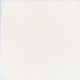

white : 94 % 


data/squares/labeled/empty/0065-h-w_2_6.jpeg


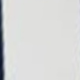

white : 78 % 


data/squares/labeled/empty/9590910c-dcaa-446b-897c-43cda5eb5286.jpg


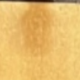

empty : 65 % 


data/squares/labeled/empty/0063-v-b_1_2.jpeg


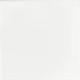

white : 96 % 


data/squares/labeled/empty/0b925197-e09f-4091-8aa9-51f9f42b1d79.jpg


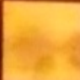

empty : 69 % 


data/squares/labeled/empty/0065-h-w_2_4.jpeg


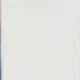

white : 86 % 


data/squares/labeled/empty/0051-v-b_1_2.jpeg


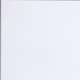

white : 97 % 


data/squares/labeled/empty/0008-v-w_7_2.jpeg


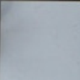

empty : 79 % 


data/squares/labeled/empty/3d0de877-bf05-42a2-bf4b-3d3aca669f82.jpg


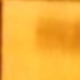

empty : 63 % 


data/squares/labeled/empty/0058-h-b_2_2.jpeg


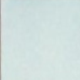

white : 77 % 


data/squares/labeled/empty/71880135-8b6f-493b-8e2e-0bd692fddc34.jpg


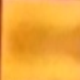

empty : 67 % 


data/squares/labeled/empty/c6ce308b-e837-49cf-b416-0c2dec50f998.jpg


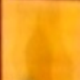

empty : 70 % 


data/squares/labeled/empty/0053-v-b_1_3.jpeg


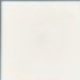

white : 92 % 


data/squares/labeled/empty/0029-h-w_4_7.jpeg


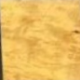

empty : 61 % 


data/squares/labeled/empty/0044-h-w_2_2.jpeg


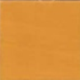

empty : 81 % 


data/squares/labeled/empty/0048-h-b_3_3.jpeg


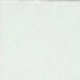

white : 92 % 


data/squares/labeled/empty/0044-h-w_3_7.jpeg


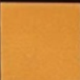

empty : 82 % 


data/squares/labeled/empty/febc771e-17ea-460e-bc37-17c8a7def582.jpg


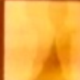

empty : 72 % 


data/squares/labeled/empty/0015-h-b_5_7.jpeg


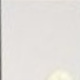

white : 81 % 


data/squares/labeled/empty/2de4c17c-6b23-4c67-9cf3-4b69fe4e9f8d.jpg


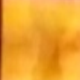

empty : 74 % 


data/squares/labeled/empty/0044-h-w_5_7.jpeg


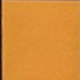

empty : 81 % 


data/squares/labeled/empty/0003-h-b_4_6.jpeg


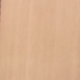

empty : 71 % 


data/squares/labeled/empty/0063-v-w_0_3.jpeg


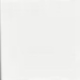

white : 96 % 


data/squares/labeled/empty/1ad5e3ee-d0f0-43ae-a3eb-444ea3710885.jpg


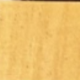

empty : 63 % 


data/squares/labeled/empty/78c6cfe0-73f5-4e7a-a9ff-46a3bf63db12.jpg


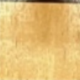

empty : 56 % 


data/squares/labeled/empty/55bb3696-1edf-4d5d-b0ac-deac0a236f0c.jpg


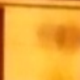

empty : 62 % 


data/squares/labeled/empty/0029-h-w_2_7.jpeg


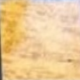

white : 73 % 


data/squares/labeled/empty/aac9e051-ef77-4136-8c68-08f53b51c525.jpg


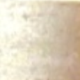

white : 72 % 


data/squares/labeled/empty/be552fee-3167-49f9-9e3c-8e49de4d9f8e.jpg


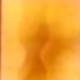

empty : 75 % 


data/squares/labeled/empty/0010-h-b_3_1.jpeg


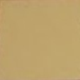

empty : 78 % 


data/squares/labeled/empty/0060-h-b_5_7.jpeg


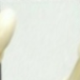

white : 92 % 


data/squares/labeled/empty/0063-v-b_5_4.jpeg


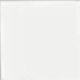

white : 96 % 


data/squares/labeled/empty/0019-h-w_2_0.jpeg


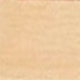

white : 50 % 


data/squares/labeled/empty/29c469b9-3f00-418c-aec3-68c774f353a4.jpg


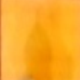

empty : 68 % 


data/squares/labeled/empty/0004-h-b_4_0.jpeg


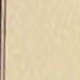

empty : 56 % 


data/squares/labeled/empty/0012-h-w_3_3.jpeg


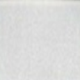

white : 74 % 


data/squares/labeled/empty/7c3252a9-c086-414e-9593-975e09a6fd25.jpg


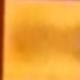

empty : 66 % 


data/squares/labeled/empty/0019-h-w_3_5.jpeg


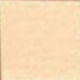

white : 77 % 


data/squares/labeled/empty/0005-h-b_3_7.jpeg


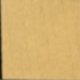

empty : 70 % 


data/squares/labeled/empty/0029-h-w_2_1.jpeg


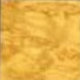

empty : 67 % 


data/squares/labeled/empty/0026-v-b_4_3.jpeg


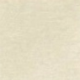

white : 61 % 


data/squares/labeled/empty/dc1251fe-d510-43a8-b555-d592af1f7514.jpg


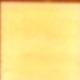

white : 78 % 


data/squares/labeled/empty/0060-h-b_5_1.jpeg


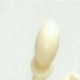

white : 89 % 


data/squares/labeled/empty/e52e3c3b-604a-4bac-a574-28c44d2fb590.jpg


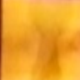

empty : 74 % 


data/squares/labeled/empty/0005-h-b_3_1.jpeg


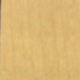

empty : 69 % 


data/squares/labeled/empty/2f991bd3-563d-4db3-b26e-e1ddee5dde4d.jpg


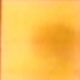

empty : 61 % 


data/squares/labeled/empty/0063-v-b_7_2.jpeg


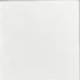

white : 92 % 


data/squares/labeled/empty/0063-v-w_0_5.jpeg


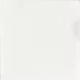

white : 95 % 


data/squares/labeled/empty/0001-h-w_4_6.jpeg


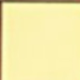

white : 85 % 


data/squares/labeled/empty/069cc72c-1207-49f1-ab87-8882982e1a75.jpg


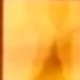

empty : 72 % 


data/squares/labeled/empty/0063-v-b_3_4.jpeg


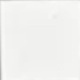

white : 96 % 


data/squares/labeled/empty/0029-h-w_3_6.jpeg


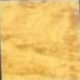

empty : 55 % 


data/squares/labeled/empty/0065-h-w_5_1.jpeg


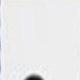

white : 95 % 


data/squares/labeled/empty/0058-h-b_2_0.jpeg


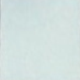

white : 78 % 


data/squares/labeled/empty/0044-h-w_4_0.jpeg


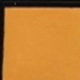

empty : 81 % 


data/squares/labeled/empty/b83fe2e3-49c6-4d23-b931-8b758a727e04.jpg


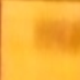

empty : 64 % 


data/squares/labeled/empty/6f2476dd-3952-4f8c-87f7-e073819cac53.jpg


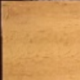

empty : 78 % 


data/squares/labeled/empty/0010-h-b_4_6.jpeg


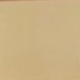

empty : 72 % 


data/squares/labeled/empty/0010-h-b_2_0.jpeg


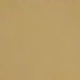

empty : 81 % 


data/squares/labeled/empty/bbee5375-1ccd-4056-9d31-10948214ef84.jpg


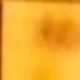

empty : 69 % 


data/squares/labeled/empty/0026-v-b_1_4.jpeg


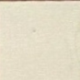

white : 64 % 


data/squares/labeled/empty/0015-h-b_2_0.jpeg


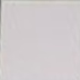

empty : 59 % 


data/squares/labeled/empty/0063-v-w_2_3.jpeg


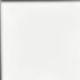

white : 96 % 


data/squares/labeled/empty/0003-h-b_3_5.jpeg


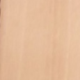

empty : 69 % 


data/squares/labeled/empty/45751a3b-89ca-48f6-9e89-4afe82cca701.jpg


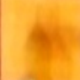

empty : 72 % 


data/squares/labeled/empty/0060-h-b_2_0.jpeg


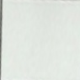

white : 85 % 


data/squares/labeled/empty/2b8e18fe-7257-476e-9141-2cc525727d7f.jpg


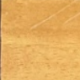

empty : 69 % 


data/squares/labeled/empty/0004-h-b_3_3.jpeg


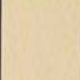

empty : 54 % 


data/squares/labeled/empty/0044-h-w_2_4.jpeg


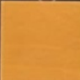

empty : 81 % 


data/squares/labeled/empty/80162961-3e1a-4763-877c-05e9f9bff6d9.jpg


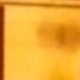

empty : 63 % 


data/squares/labeled/empty/0043-v-w_0_3.jpeg


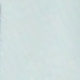

white : 72 % 


data/squares/labeled/empty/0001-h-w_2_0.jpeg


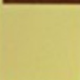

empty : 70 % 


data/squares/labeled/empty/30a1427d-b40e-4e55-8bc5-612cdc1f103e.jpg


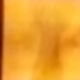

empty : 73 % 


data/squares/labeled/empty/0058-h-b_2_4.jpeg


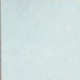

white : 80 % 


data/squares/labeled/empty/0019-h-w_3_3.jpeg


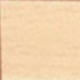

white : 68 % 


data/squares/labeled/empty/94d061e5-65b0-4794-b9c2-950e549a02ca.jpg


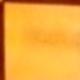

empty : 58 % 


data/squares/labeled/empty/0010-h-b_2_6.jpeg


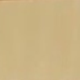

empty : 70 % 


data/squares/labeled/empty/302a67a5-a54d-4da8-8953-55e1ea817931.jpg


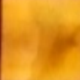

empty : 77 % 


data/squares/labeled/empty/b3791b83-08fd-4b7c-9417-be067bf50c89.jpg


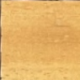

empty : 67 % 


data/squares/labeled/empty/0005-h-b_3_5.jpeg


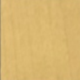

empty : 69 % 


data/squares/labeled/empty/0053-v-b_0_2.jpeg


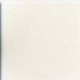

white : 87 % 


data/squares/labeled/empty/0048-h-b_3_1.jpeg


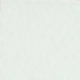

white : 91 % 


data/squares/labeled/empty/0065-h-w_5_3.jpeg


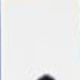

white : 96 % 


data/squares/labeled/empty/5c147c50-a561-49a0-bebd-940cd3d521b4.jpg


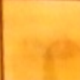

empty : 71 % 


data/squares/labeled/empty/3075249b-0a15-47d0-8ff7-557f9e39d7ef.jpg


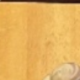

empty : 68 % 


data/squares/labeled/empty/0029-h-w_5_2.jpeg


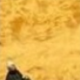

empty : 63 % 


data/squares/labeled/empty/63b5ebf2-3f32-42df-af13-b2179cb3acc3.jpg


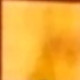

empty : 67 % 


data/squares/labeled/empty/0063-v-w_1_2.jpeg


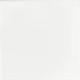

white : 96 % 


data/squares/labeled/empty/0051-v-b_4_3.jpeg


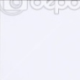

white : 98 % 


data/squares/labeled/empty/1f7af856-9db7-49f8-bae7-5b9f7608b0a9.jpg


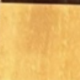

empty : 66 % 


data/squares/labeled/empty/75d899af-a08e-44a6-8c7d-7bf5578b2295.jpg


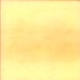

white : 84 % 


data/squares/labeled/empty/0060-h-b_2_6.jpeg


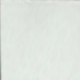

white : 84 % 


data/squares/labeled/empty/0003-h-b_3_3.jpeg


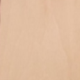

empty : 67 % 


data/squares/labeled/empty/e2c68c74-96f4-44b5-aeb2-e585075b2961.jpg


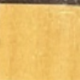

empty : 66 % 


data/squares/labeled/empty/0048-h-b_3_5.jpeg


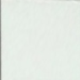

white : 91 % 


data/squares/labeled/empty/0012-h-w_4_2.jpeg


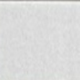

white : 71 % 


data/squares/labeled/empty/0003-h-b_3_1.jpeg


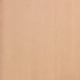

empty : 71 % 


data/squares/labeled/empty/c6d96338-ff55-4e6e-b4ab-0e9a9bcb09ed.jpg


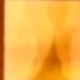

empty : 72 % 


data/squares/labeled/empty/0063-v-w_3_2.jpeg


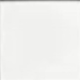

white : 96 % 


data/squares/labeled/empty/e3f60490-2cd6-4ced-93a0-8fa32ad7d1c9.jpg


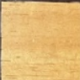

empty : 63 % 


data/squares/labeled/empty/0005-h-b_4_0.jpeg


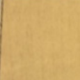

empty : 72 % 


data/squares/labeled/empty/10a53fe6-18cc-40a1-89ed-b333af091e56.jpg


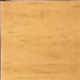

empty : 73 % 


data/squares/labeled/empty/0051-v-b_7_2.jpeg


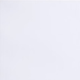

white : 97 % 


data/squares/labeled/empty/0001-h-w_3_7.jpeg


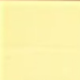

white : 85 % 


data/squares/labeled/empty/faf0575d-c8d8-45f3-8f93-3cc8997d4deb.jpg


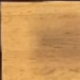

empty : 85 % 


data/squares/labeled/empty/ed81ad73-e799-449b-ad9d-eb58f46a91cd.jpg


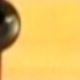

white : 65 % 


data/squares/labeled/empty/156599b2-8563-4711-8da4-cac94239c9aa.jpg


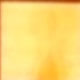

white : 65 % 


data/squares/labeled/empty/badd6eb4-b065-456c-88e5-99afcad29d27.jpg


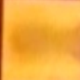

empty : 64 % 


data/squares/labeled/empty/db0f3457-60e5-438e-a718-8648a2462658.jpg


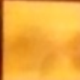

empty : 69 % 


data/squares/labeled/empty/2ebebec0-c5f0-4e63-8e83-a7cc0cc2a60e.jpg


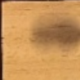

empty : 88 % 


data/squares/labeled/empty/fa5f8f84-44dd-40b7-a75f-fd87d7b9eaf5.jpg


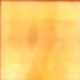

white : 59 % 


data/squares/labeled/empty/7b88f84a-0316-4420-8b1e-6da4ec9663d4.jpg


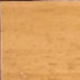

empty : 76 % 


data/squares/labeled/empty/0003-h-b_5_7.jpeg


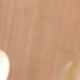

empty : 88 % 


data/squares/labeled/empty/c61c9d6b-e3a8-4e43-b340-9599e4679578.jpg


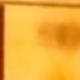

empty : 61 % 


data/squares/labeled/empty/0044-h-w_4_4.jpeg


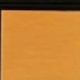

empty : 81 % 


data/squares/labeled/empty/b86e3284-4745-486a-979d-1e9cc2cc0472.jpg


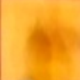

empty : 69 % 


data/squares/labeled/empty/0010-h-b_4_4.jpeg


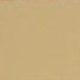

empty : 73 % 


data/squares/labeled/empty/0015-h-b_4_6.jpeg


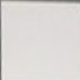

white : 70 % 


data/squares/labeled/empty/0058-h-b_3_3.jpeg


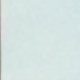

white : 81 % 


data/squares/labeled/empty/0005-h-b_5_3.jpeg


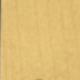

empty : 67 % 


data/squares/labeled/empty/324b7fae-77df-4d1b-a9c3-07a08e269c4b.jpg


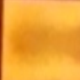

empty : 67 % 


data/squares/labeled/empty/2fc7e6aa-fc89-4b95-bc97-342cd5a20186.jpg


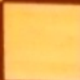

white : 55 % 


data/squares/labeled/empty/0051-v-b_3_2.jpeg


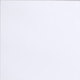

white : 97 % 


data/squares/labeled/empty/0053-v-b_7_3.jpeg


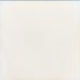

white : 89 % 


data/squares/labeled/empty/0010-h-b_5_1.jpeg


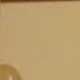

empty : 78 % 


data/squares/labeled/empty/0003-h-b_5_3.jpeg


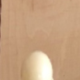

empty : 64 % 


data/squares/labeled/empty/0053-v-b_4_4.jpeg


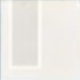

white : 90 % 


data/squares/labeled/empty/0015-h-b_2_2.jpeg


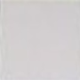

empty : 54 % 


data/squares/labeled/empty/0012-h-w_2_0.jpeg


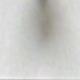

empty : 74 % 


data/squares/labeled/empty/7a7448e9-c632-4e41-abb7-054693f7ea9f.jpg


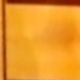

empty : 68 % 


data/squares/labeled/empty/a0d24c50-079b-42aa-ae76-db9d2ec9c0fd.jpg


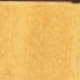

empty : 68 % 


data/squares/labeled/empty/0015-h-b_5_5.jpeg


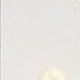

white : 86 % 


data/squares/labeled/empty/0004-h-b_2_2.jpeg


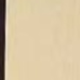

empty : 59 % 


data/squares/labeled/empty/0051-v-b_5_2.jpeg


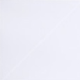

white : 97 % 


data/squares/labeled/empty/0065-h-w_2_0.jpeg


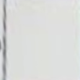

white : 76 % 


data/squares/labeled/empty/0043-v-w_6_3.jpeg


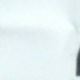

white : 98 % 


data/squares/labeled/empty/9f450878-d896-42ae-be2e-72912eb76cc7.jpg


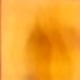

empty : 69 % 


data/squares/labeled/empty/904c6da5-1091-40b0-801b-b99ca3175584.jpg


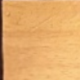

empty : 69 % 


data/squares/labeled/empty/0010-h-b_3_5.jpeg


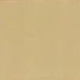

empty : 70 % 


data/squares/labeled/empty/0001-h-w_3_1.jpeg


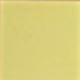

empty : 66 % 


data/squares/labeled/empty/c75d3386-b604-48fc-9eaf-d89bb3adcee3.jpg


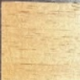

white : 57 % 


data/squares/labeled/empty/89fa11d7-7ee1-46bc-a420-a9d63ec5a5b6.jpg


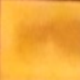

empty : 64 % 


data/squares/labeled/empty/0048-h-b_4_2.jpeg


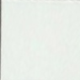

white : 94 % 


data/squares/labeled/empty/0063-v-w_4_3.jpeg


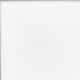

white : 96 % 


data/squares/labeled/empty/0051-v-b_5_4.jpeg


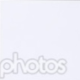

white : 98 % 


data/squares/labeled/empty/6bcfce4a-a2e5-445f-bfde-8200ce79b9b9.jpg


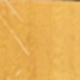

empty : 70 % 


data/squares/labeled/empty/4c961b1b-3e28-4280-ad0d-640ab2761e75.jpg


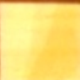

white : 67 % 


data/squares/labeled/empty/0048-h-b_3_7.jpeg


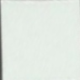

white : 90 % 


data/squares/labeled/empty/0003-h-b_2_0.jpeg


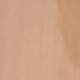

empty : 79 % 


data/squares/labeled/empty/98f0b0c3-50c8-488c-9005-da01b8e3e7f9.jpg


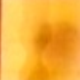

empty : 69 % 


data/squares/labeled/empty/a099120a-0e4e-4fd5-b532-6165b74c4eb9.jpg


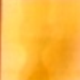

empty : 65 % 


data/squares/labeled/empty/0012-h-w_5_7.jpeg


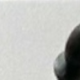

white : 60 % 


data/squares/labeled/empty/3f091d1e-c4f9-4f32-adab-bf428e8f55d7.jpg


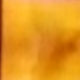

empty : 76 % 


data/squares/labeled/empty/0001-h-w_5_1.jpeg


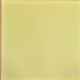

empty : 63 % 


data/squares/labeled/empty/0060-h-b_4_0.jpeg


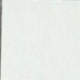

white : 93 % 


data/squares/labeled/empty/6bef7f1e-3057-4c96-a1ad-74579d830f05.jpg


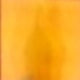

empty : 69 % 


data/squares/labeled/empty/0980da67-e4cc-4cda-af0a-c1c4525f0c89.jpg


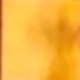

empty : 59 % 


data/squares/labeled/empty/0043-v-w_7_4.jpeg


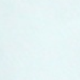

white : 97 % 


data/squares/labeled/empty/0051-v-b_1_4.jpeg


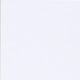

white : 98 % 


data/squares/labeled/empty/0051-v-b_2_5.jpeg


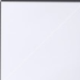

white : 98 % 


data/squares/labeled/empty/c01507e1-2c14-45ce-a54a-0e168b309686.jpg


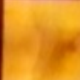

empty : 75 % 


data/squares/labeled/empty/0063-v-w_7_2.jpeg


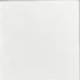

white : 92 % 


data/squares/labeled/empty/0063-v-w_5_4.jpeg


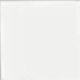

white : 96 % 


data/squares/labeled/empty/33c8ef1d-553d-4b5c-b497-a3818ed23b0c.jpg


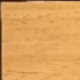

empty : 74 % 


data/squares/labeled/empty/0048-h-b_2_6.jpeg


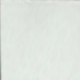

white : 84 % 


data/squares/labeled/empty/0048-h-b_5_1.jpeg


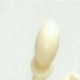

white : 89 % 


data/squares/labeled/empty/0043-v-w_2_3.jpeg


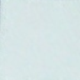

white : 85 % 


data/squares/labeled/empty/6420c24c-66e8-4518-864f-694220326cbb.jpg


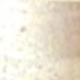

white : 94 % 


data/squares/labeled/empty/0060-h-b_2_4.jpeg


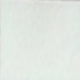

white : 86 % 


data/squares/labeled/empty/d831b045-7bbd-42e7-91f8-0f2f1a9a4381.jpg


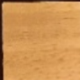

empty : 81 % 


data/squares/labeled/empty/0001-h-w_4_4.jpeg


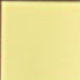

white : 59 % 


data/squares/labeled/empty/0001-h-w_3_3.jpeg


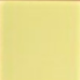

white : 54 % 


data/squares/labeled/empty/4ef953d3-30de-4328-8d39-619dd046b631.jpg


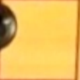

white : 65 % 


data/squares/labeled/empty/0029-h-w_5_6.jpeg


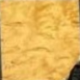

empty : 65 % 


data/squares/labeled/empty/6f15cda1-693b-4baf-846a-39a8f43e7d5b.jpg


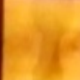

empty : 75 % 


data/squares/labeled/empty/0058-h-b_4_6.jpeg


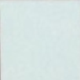

white : 84 % 


data/squares/labeled/empty/0008-v-w_4_3.jpeg


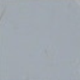

empty : 86 % 


data/squares/labeled/empty/0063-v-b_7_4.jpeg


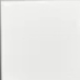

white : 92 % 


data/squares/labeled/empty/49f9277b-ca76-4175-9e48-8be50a101f6b.jpg


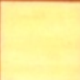

white : 89 % 


data/squares/labeled/empty/0019-h-w_2_6.jpeg


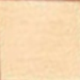

white : 78 % 


data/squares/labeled/empty/0043-v-w_7_2.jpeg


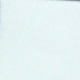

white : 97 % 


data/squares/labeled/empty/58b2ff06-7057-4837-832f-ea09bea2150f.jpg


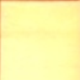

white : 91 % 


data/squares/labeled/empty/0004-h-b_4_6.jpeg


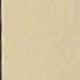

empty : 67 % 


data/squares/labeled/empty/eba3445b-c98e-47fb-9f47-ff1240ba66cf.jpg


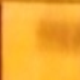

empty : 65 % 


data/squares/labeled/empty/0048-h-b_4_0.jpeg


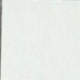

white : 93 % 


data/squares/labeled/empty/0026-v-b_7_4.jpeg


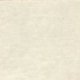

white : 80 % 


data/squares/labeled/empty/0063-v-b_5_2.jpeg


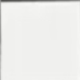

white : 96 % 


data/squares/labeled/empty/0065-h-w_4_6.jpeg


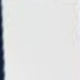

white : 90 % 


data/squares/labeled/empty/0048-h-b_2_0.jpeg


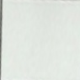

white : 85 % 


data/squares/labeled/empty/0010-h-b_4_0.jpeg


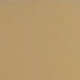

empty : 82 % 


data/squares/labeled/empty/0029-h-w_5_4.jpeg


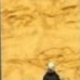

empty : 71 % 


data/squares/labeled/empty/4e7f70e4-1483-49d5-99a2-ce70791d4be7.jpg


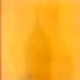

empty : 68 % 


data/squares/labeled/empty/016618e6-21c8-4f70-9949-d644635bab1c.jpg


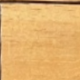

empty : 68 % 


data/squares/labeled/empty/5d65d230-c0a9-49bb-861b-cbb5d3efe99b.jpg


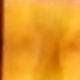

empty : 75 % 


data/squares/labeled/empty/0005-h-b_5_7.jpeg


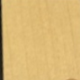

empty : 67 % 


data/squares/labeled/empty/0003-h-b_2_2.jpeg


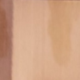

empty : 75 % 


data/squares/labeled/empty/14ba14fe-8b4d-4cbe-b2c8-71b196275bb4.jpg


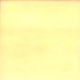

white : 89 % 


data/squares/labeled/empty/0a358501-4d26-46c6-be08-810cbbe197f9.jpg


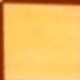

white : 59 % 


data/squares/labeled/empty/0043-v-w_2_5.jpeg


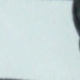

white : 81 % 


data/squares/labeled/empty/0029-h-w_2_5.jpeg


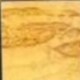

empty : 50 % 


data/squares/labeled/empty/a93513d0-5dd8-4f0b-8fc8-47dd94a40257.jpg


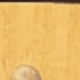

empty : 64 % 


data/squares/labeled/empty/0026-v-b_1_2.jpeg


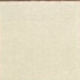

white : 62 % 


data/squares/labeled/empty/0058-h-b_3_1.jpeg


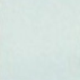

white : 81 % 


data/squares/labeled/empty/0065-h-w_4_4.jpeg


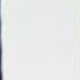

white : 94 % 


data/squares/labeled/empty/0010-h-b_3_7.jpeg


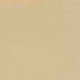

empty : 67 % 


data/squares/labeled/empty/a4609b49-a9fa-420e-ad44-eff85aa3de74.jpg


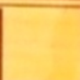

white : 61 % 


data/squares/labeled/empty/0001-h-w_2_6.jpeg


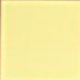

white : 81 % 


data/squares/labeled/empty/0060-h-b_5_3.jpeg


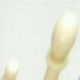

white : 94 % 


data/squares/labeled/empty/11935b09-09ef-4644-b049-f353c8b1722d.jpg


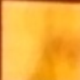

empty : 66 % 


data/squares/labeled/empty/0063-v-w_2_5.jpeg


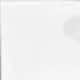

white : 96 % 


data/squares/labeled/empty/0008-v-w_6_3.jpeg


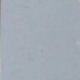

empty : 83 % 


data/squares/labeled/empty/af9401b9-c636-4aae-9cea-048e5a4377c2.jpg


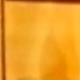

empty : 68 % 


data/squares/labeled/empty/0003-h-b_3_7.jpeg


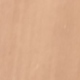

empty : 75 % 


data/squares/labeled/empty/0029-h-w_4_5.jpeg


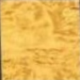

empty : 68 % 


data/squares/labeled/empty/0048-h-b_2_4.jpeg


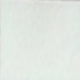

white : 86 % 


data/squares/labeled/empty/0048-h-b_4_6.jpeg


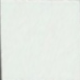

white : 92 % 


data/squares/labeled/empty/093e3f83-9f39-442f-afb8-1d9d1d1a2676.jpg


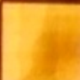

empty : 70 % 


data/squares/labeled/empty/0d50ea47-3bf4-4128-8a0e-a066618402f8.jpg


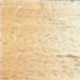

white : 50 % 


data/squares/labeled/empty/0053-v-b_0_4.jpeg


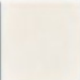

white : 86 % 


data/squares/labeled/empty/6b328ffa-be3b-4ba7-976a-7060a13eaef1.jpg


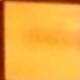

empty : 57 % 


data/squares/labeled/empty/d8d6f490-9484-4869-a83c-32c1e0127d4a.jpg


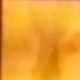

empty : 74 % 


data/squares/labeled/empty/43034794-be18-4f84-930d-a908668da7ff.jpg


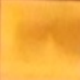

empty : 64 % 


data/squares/labeled/empty/0044-h-w_2_0.jpeg


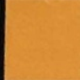

empty : 81 % 


data/squares/labeled/empty/0043-v-w_4_3.jpeg


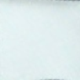

white : 95 % 


data/squares/labeled/empty/0001-h-w_5_5.jpeg


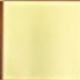

white : 73 % 


data/squares/labeled/empty/42d269e1-4a99-4510-b87d-9282026ac008.jpg


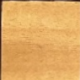

empty : 72 % 


data/squares/labeled/empty/0058-h-b_4_4.jpeg


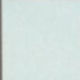

white : 81 % 


data/squares/labeled/empty/0012-h-w_2_4.jpeg


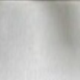

empty : 62 % 


data/squares/labeled/empty/84f4060f-8e5b-4b33-b678-fe28b3254653.jpg


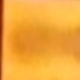

empty : 67 % 


data/squares/labeled/empty/0026-v-b_2_3.jpeg


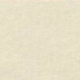

white : 67 % 


data/squares/labeled/empty/6ece4b76-eb5a-4afa-895a-d7cab23026ae.jpg


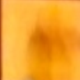

empty : 68 % 


data/squares/labeled/empty/0be665f1-a8ea-48e6-9d01-e693772120dd.jpg


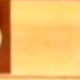

white : 73 % 


data/squares/labeled/empty/0004-h-b_2_0.jpeg


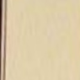

empty : 59 % 


data/squares/labeled/empty/9198a4f9-899a-422f-b510-a65ade41edd7.jpg


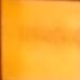

empty : 60 % 


data/squares/labeled/empty/0060-h-b_3_5.jpeg


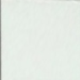

white : 91 % 


data/squares/labeled/empty/0065-h-w_3_1.jpeg


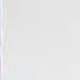

white : 90 % 


data/squares/labeled/empty/0015-h-b_2_6.jpeg


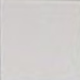

empty : 59 % 


data/squares/labeled/empty/577bbc3c-552b-48d9-b144-4ab4fe12664c.jpg


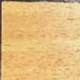

empty : 59 % 


data/squares/labeled/empty/0026-v-b_5_2.jpeg


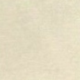

white : 59 % 


data/squares/labeled/empty/0001-h-w_4_2.jpeg


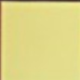

empty : 55 % 


data/squares/labeled/empty/0044-h-w_5_3.jpeg


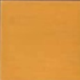

empty : 80 % 


data/squares/labeled/empty/3e47f462-72e9-44dd-a052-e7d40503c0f5.jpg


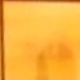

empty : 70 % 


data/squares/labeled/empty/0063-v-b_4_5.jpeg


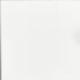

white : 96 % 


data/squares/labeled/empty/0029-h-w_2_3.jpeg


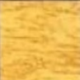

empty : 66 % 


data/squares/labeled/empty/a353cc08-e591-4099-93ab-33e3e5df79d1.jpg


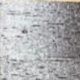

empty : 84 % 


data/squares/labeled/empty/0ed0de4b-070e-493b-87f2-b3026f796083.jpg


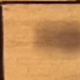

empty : 83 % 


data/squares/labeled/empty/ebbbcc55-e1ee-444f-bcad-7f56b4d43391.jpg


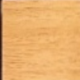

empty : 67 % 


data/squares/labeled/empty/09842486-23a0-48e0-b524-fd531fadf9d0.jpg


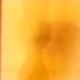

empty : 68 % 


data/squares/labeled/empty/0003-h-b_2_6.jpeg


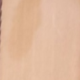

empty : 66 % 


data/squares/labeled/empty/0012-h-w_4_4.jpeg


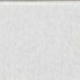

white : 78 % 


data/squares/labeled/empty/2a036617-748a-42a9-933f-e2264aafa036.jpg


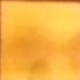

empty : 69 % 


data/squares/labeled/empty/6de4e2a1-e160-4b55-b600-1fbd9f6adabc.jpg


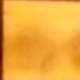

empty : 70 % 


data/squares/labeled/empty/6d0c99f2-1c9a-4afb-9965-9ec12d42c658.jpg


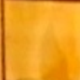

empty : 69 % 


data/squares/labeled/empty/3c776927-93df-4313-88d9-ea5d4100a7f9.jpg


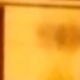

empty : 61 % 


data/squares/labeled/empty/0048-h-b_5_3.jpeg


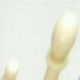

white : 94 % 


data/squares/labeled/empty/c2661165-cacc-4b0a-bffa-2cbc77ecf88b.jpg


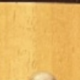

empty : 68 % 


data/squares/labeled/empty/49bc4418-485a-4cac-8274-abe18e6154ed.jpg


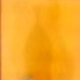

empty : 69 % 


data/squares/labeled/empty/0026-v-b_5_4.jpeg


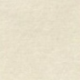

white : 68 % 


data/squares/labeled/empty/bbdbfa68-50d3-475e-9389-e37630e6cba0.jpg


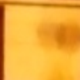

empty : 62 % 


data/squares/labeled/empty/0001-h-w_5_3.jpeg


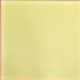

white : 58 % 


data/squares/labeled/empty/b79c85ed-9786-4537-bfdc-a31c89a0bf62.jpg


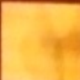

empty : 60 % 


data/squares/labeled/empty/0063-v-w_6_5.jpeg


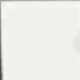

white : 95 % 


data/squares/labeled/empty/0063-v-w_7_4.jpeg


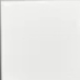

white : 92 % 


data/squares/labeled/empty/7b4cbc08-345e-413e-9427-a78f009c69ab.jpg


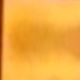

empty : 64 % 


data/squares/labeled/empty/0026-v-b_4_5.jpeg


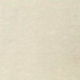

white : 55 % 


data/squares/labeled/empty/0019-h-w_5_3.jpeg


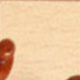

white : 75 % 


data/squares/labeled/empty/19725ab7-adf3-4ff5-b14e-90bf2eb296cb.jpg


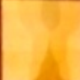

empty : 66 % 


data/squares/labeled/empty/2ec37f27-28a4-4892-be0e-a6419b58bda8.jpg


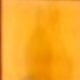

empty : 69 % 


data/squares/labeled/empty/dc3faad6-72ba-434c-bfae-2dc660499074.jpg


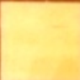

white : 81 % 


data/squares/labeled/empty/0060-h-b_3_3.jpeg


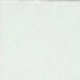

white : 92 % 


data/squares/labeled/empty/cf29f935-f9eb-4c82-8d46-dfd3af259d09.jpg


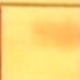

white : 74 % 


data/squares/labeled/empty/0043-v-w_3_4.jpeg


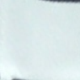

white : 92 % 


data/squares/labeled/empty/0005-h-b_2_0.jpeg


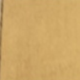

empty : 74 % 


data/squares/labeled/empty/3f3cc5d0-1c25-428a-898d-04c2d1892a5d.jpg


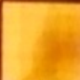

empty : 70 % 


data/squares/labeled/empty/0053-v-b_5_5.jpeg


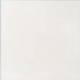

white : 90 % 


data/squares/labeled/empty/0003-h-b_2_4.jpeg


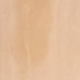

empty : 66 % 


data/squares/labeled/empty/0012-h-w_3_1.jpeg


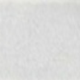

white : 71 % 


data/squares/labeled/empty/0051-v-b_7_4.jpeg


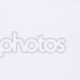

white : 97 % 


data/squares/labeled/empty/a4a6df1a-1d6a-4ab3-96b7-7e5b51978e4c.jpg


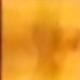

empty : 76 % 


data/squares/labeled/empty/0019-h-w_5_1.jpeg


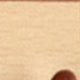

white : 55 % 


data/squares/labeled/empty/0044-h-w_2_6.jpeg


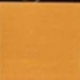

empty : 81 % 


data/squares/labeled/empty/0012-h-w_4_0.jpeg


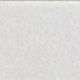

white : 65 % 


data/squares/labeled/empty/0015-h-b_5_3.jpeg


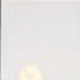

white : 90 % 


data/squares/labeled/empty/0019-h-w_4_0.jpeg


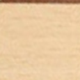

white : 54 % 


data/squares/labeled/empty/0015-h-b_3_7.jpeg


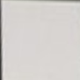

white : 53 % 


data/squares/labeled/empty/0019-h-w_4_6.jpeg


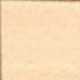

white : 81 % 


data/squares/labeled/empty/0015-h-b_3_3.jpeg


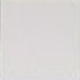

white : 65 % 


data/squares/labeled/empty/7ac6bc68-b234-4c06-9042-a4cd946006c9.jpg


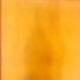

empty : 70 % 


data/squares/labeled/empty/0012-h-w_2_2.jpeg


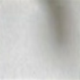

empty : 73 % 


data/squares/labeled/empty/101cc027-9eec-4d18-90cc-03fbda55a7df.jpg


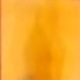

empty : 69 % 


data/squares/labeled/empty/0044-h-w_5_5.jpeg


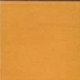

empty : 80 % 


data/squares/labeled/empty/0015-h-b_3_5.jpeg


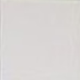

white : 59 % 


data/squares/labeled/empty/1e63cb15-ab2d-4191-bdcc-07e95580caae.jpg


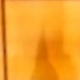

empty : 71 % 


data/squares/labeled/empty/b95d338c-57d0-40b5-847b-13693644c49e.jpg


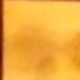

empty : 71 % 


data/squares/labeled/empty/b8793f21-eeaf-4aa1-9d9a-de16128605a1.jpg


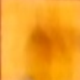

empty : 71 % 


data/squares/labeled/empty/0026-v-b_6_5.jpeg


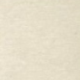

white : 68 % 


data/squares/labeled/empty/cf0d39ab-4b28-4c74-893f-1c959bda42d1.jpg


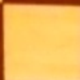

white : 57 % 


data/squares/labeled/empty/4f0323e9-1a10-4302-a214-94071ceafd2b.jpg


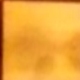

empty : 69 % 


data/squares/labeled/empty/0029-h-w_3_0.jpeg


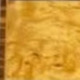

empty : 75 % 


data/squares/labeled/empty/0026-v-b_0_3.jpeg


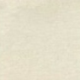

white : 65 % 


data/squares/labeled/empty/0026-v-b_3_4.jpeg


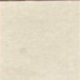

white : 57 % 


data/squares/labeled/empty/f3cd92b1-10ce-4a63-8891-7ceec3981711.jpg


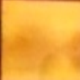

empty : 69 % 


data/squares/labeled/empty/6dd434d9-e776-4ad5-98f0-e6f8c3e4ac4a.jpg


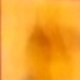

empty : 69 % 


data/squares/labeled/empty/0012-h-w_3_5.jpeg


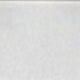

white : 72 % 


data/squares/labeled/empty/013459ec-2fa2-4ade-b6a5-8b1d15c72b24.jpg


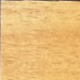

empty : 62 % 


data/squares/labeled/empty/0005-h-b_2_4.jpeg


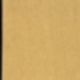

empty : 72 % 


data/squares/labeled/empty/0063-v-b_1_4.jpeg


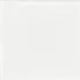

white : 95 % 


data/squares/labeled/empty/0026-v-b_0_5.jpeg


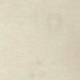

empty : 55 % 


data/squares/labeled/empty/1e40b40e-768f-4dd8-8b7a-c65d04a0a74a.jpg


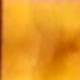

empty : 76 % 


data/squares/labeled/empty/0019-h-w_3_1.jpeg


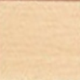

white : 59 % 


data/squares/labeled/empty/0044-h-w_5_1.jpeg


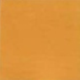

empty : 80 % 


data/squares/labeled/empty/0053-v-b_6_2.jpeg


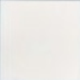

white : 91 % 


data/squares/labeled/empty/0012-h-w_3_7.jpeg


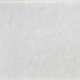

white : 61 % 


data/squares/labeled/empty/0044-h-w_4_2.jpeg


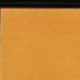

empty : 81 % 


data/squares/labeled/empty/a3d340a5-f6ea-4410-b2a0-a5cd3d5acac3.jpg


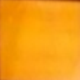

empty : 68 % 


data/squares/labeled/empty/0053-v-b_2_2.jpeg


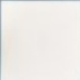

white : 93 % 


data/squares/labeled/empty/0012-h-w_4_6.jpeg


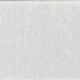

white : 67 % 


data/squares/labeled/empty/0019-h-w_5_7.jpeg


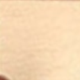

white : 73 % 


data/squares/labeled/empty/66506feb-a1e3-4b62-bf3c-fb707700ebd7.jpg


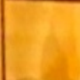

empty : 68 % 


data/squares/labeled/empty/0a27994b-e00f-42a8-9ef3-267251eb0345.jpg


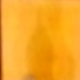

empty : 69 % 




In [81]:
# # Uncomment the below two lines if you want to use the pre trained model for 50 epoch
model = SquareClassificationModel()
model.load_state_dict(torch.load('model_50.pth', map_location=device))
#model.cuda()
model.eval()

from glob import glob
from random import shuffle

std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)


denormalize= transforms.Compose([
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

classes = ["black", "empty", "white"]

import cv2

expected_class = "empty"

with torch.no_grad():
    images = glob(f'data/squares/labeled/{expected_class}/*')  # /content/drive/MyDrive/squares/labeled/white/*
    shuffle(images)
    for impath in images:
        image = cv2.imread(impath)
        image_orig = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        image = torchvision.transforms.Compose([
            torchvision.transforms.Resize(100),
            torchvision.transforms.CenterCrop(95),
            torchvision.transforms.Resize(80),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)

        image_tensor = image.view(1, 3, 80, 80).to(device)
        prediction = model(image_tensor)

        predicted_class_id = prediction.argmax().data.item()
        predicted_class = classes[predicted_class_id]

        probability = torch.nn.Softmax(dim=1)(prediction)[0] * 100
        probability = probability.int().data.cpu().numpy()[predicted_class_id]
        if predicted_class != expected_class or probability < 90:
            print(impath)
            display(denormalize(image))
            print(predicted_class, ':', probability, '%', '\n\n')

#model.train()
#pass